Create Data Frame for Unemployment Statistics, Quality of Life and Cost of Living Statistics, and US City stats

In [ ]:
import pandas as pd
import ast

#Unemployment Rate
unemployment_df = pd.read_csv('city_unemployment_rate.csv')
unemployment_df = unemployment_df.sort_values(by='Unemployment Rate',ascending=False)

#Labor Force per City
labor_df = pd.read_csv('city_labor_force_population.csv')
labor_df = labor_df.sort_values(by='Labor Force Population',ascending=False)

#Quality of Life Ratings
quality_life_df = pd.read_csv('quality_of_life.csv')

#Cost of Living statistics
cost_living_df = pd.read_csv('cost_of_living.csv')
# cost_living_df.head()
# quality_life_df

#US Cities
cities_df = pd.read_csv('uscities.csv')
city_density_df = cities_df.sort_values(by='density',ascending=False)
city_population_df = cities_df.sort_values(by='population',ascending=False)
# cities_df.head()

# Function to safely convert string -> tuple
def str_to_tuple(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None



In [455]:
def extract_value(val):
    t = str_to_tuple(val)
    if t and t[0] != '?':
        try:
            index_value = float(t[0])
            return index_value
        except:
            return None
    else:
        return None

df_purchase_power = quality_life_df.sort_values(
    by= 'Purchasing Power Index',
    key= lambda col: col.map(extract_value),
    ascending= False,
    na_position='last'
)

df_purchase_power = df_purchase_power.drop_duplicates(subset=['City'], keep='first')
df_purchase_power.head(50)

,City,State,Purchasing Power Index,Safety Index,Health Care Index,Climate Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,ƒQuality of Life Index:
312,Merrill,WI,"('391.48', 'Very High')","('64.71', 'High')","('66.67', 'High')","('31.85', 'Moderate')","('53.17', 'Low')","('1.20', 'Very Low')","('28.50', 'Low')","('34.48', 'Low')","('282.48', 'Very High')"
645,Mackay,ID,"('216.82', 'Very High')","('50.59', 'Moderate')","('88.89', 'Very High')","('92.01', 'Very High')","('64.12', 'Moderate')","('2.20', 'Very Low')","('22.50', 'Very Low')","('31.18', 'Low')","('237.60', 'Very High')"
102,Alpharetta,GA,"('209.14', 'Very High')","('90.14', 'Very High')","('68.29', 'High')","('87.00', 'Very High')","('69.86', 'Moderate')","('5.56', 'Low')","('48.62', 'High')","('31.03', 'Low')","('227.50', 'Very High')"
12,Seattle,WA,"('188.00', 'Very High')","('45.65', 'Moderate')","('66.65', 'High')","('91.73', 'Very High')","('82.43', 'High')","('4.53', 'Very Low')","('42.57', 'High')","('40.54', 'Moderate')","('194.17', 'Very High')"
100,Renton,WA,"('187.73', 'Very High')","('64.02', 'High')","('77.78', 'High')","('90.33', 'Very High')","('67.64', 'Moderate')","('3.88', 'Very Low')","('21.75', 'Very Low')","('32.18', 'Low')","('225.36', 'Very High')"
7,Atlanta,GA,"('182.61', 'Very High')","('35.35', 'Low')","('66.97', 'High')","('89.73', 'Very High')","('70.99', 'Moderate')","('2.34', 'Very Low')","('41.37', 'High')","('45.04', 'Moderate')","('187.26', 'Very High')"
28,Indianapolis,IN,"('181.15', 'Very High')","('39.65', 'Low')","('71.40', 'High')","('69.92', 'High')","('61.65', 'Moderate')","('1.91', 'Very Low')","('29.54', 'Low')","('43.17', 'Moderate')","('192.53', 'Very High')"
56,Little Rock,AR,"('177.45', 'Very High')","('39.94', 'Low')","('66.67', 'High')","('83.82', 'Very High')","('58.52', 'Low')","('2.98', 'Very Low')","('28.10', 'Low')","('25.69', 'Low')","('205.55', 'Very High')"
409,Geneva,FL,"('174.96', 'Very High')","('69.51', 'High')","('69.90', 'High')","('82.61', 'Very High')","('112.05', 'Very High')","('11.43', 'Moderate')","('32.76', 'Low')","('24.61', 'Low')","('204.81', 'Very High')"
20,Saint Louis,MO,"('174.03', 'Very High')","('30.26', 'Low')","('73.47', 'High')","('74.75', 'High')","('62.98', 'Moderate')","('2.06', 'Very Low')","('27.07', 'Low')","('37.47', 'Low')","('192.18', 'Very High')"


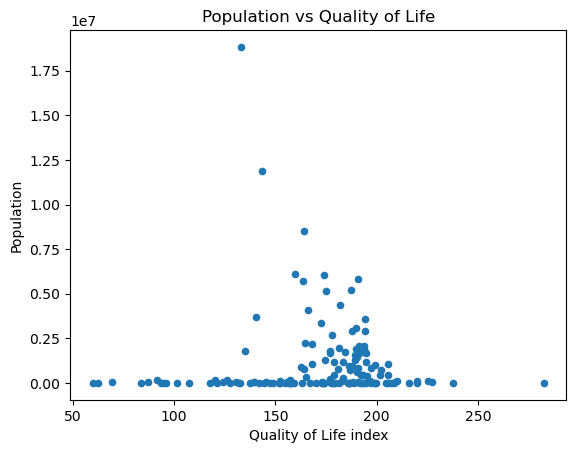

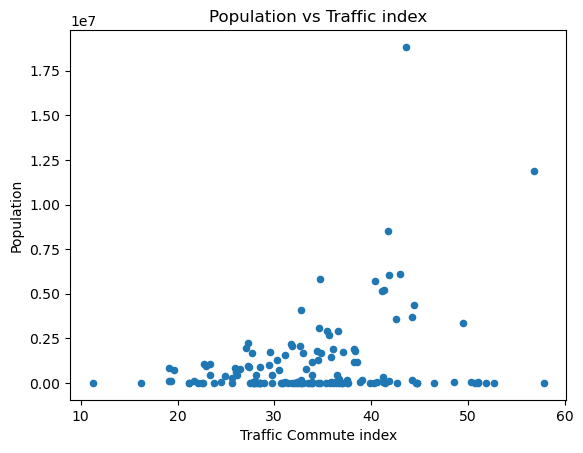

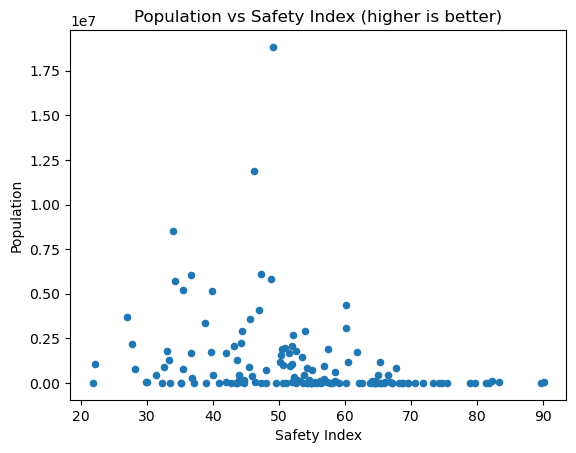

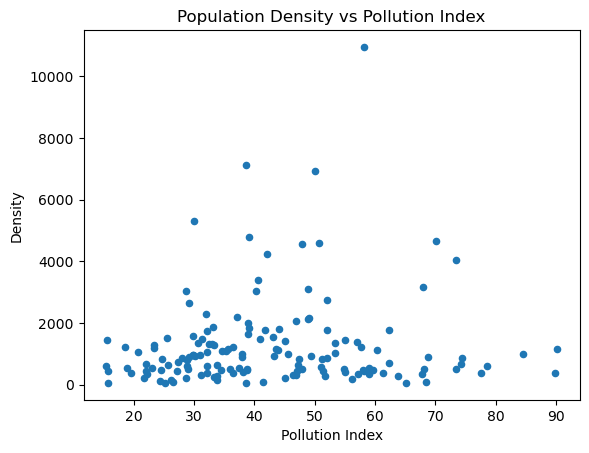

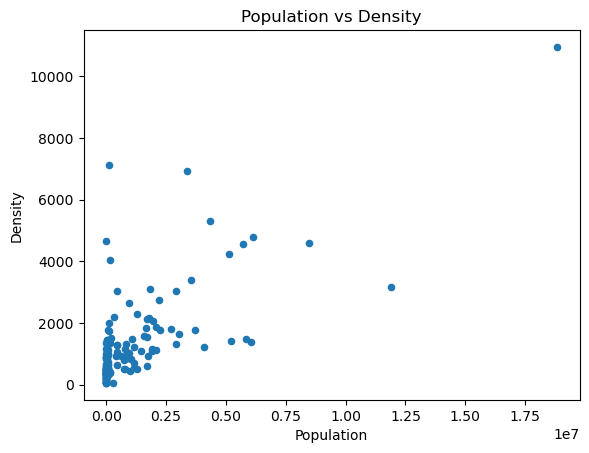

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#Build a table of the 100 most populated cities
cities = city_population_df
city_quality = []
cities_used = []

for index,row in cities.iterrows():
    city = row['city']
    population = row['population']
    density = row['density']

    if city in cities_used:
        continue
    try:
        quality_life_data = quality_life_df[quality_life_df['City'] == city]
        quality_rating = float(str_to_tuple(quality_life_data['ƒQuality of Life Index:'].values[0])[0])
        traffic = float(str_to_tuple(quality_life_data['Traffic Commute Time Index'].values[0])[0])
        pollution = float(str_to_tuple(quality_life_data['Pollution Index'].values[0])[0])
        safety = float(str_to_tuple(quality_life_data['Safety Index'].values[0])[0])
        if quality_rating:
            city_quality.append((city, quality_rating, safety, traffic, pollution, population, density))
            cities_used.append(city)
    except:
        pass

df2= pd.DataFrame(city_quality,columns=['City','Quality of Life index', 'Safety Index','Traffic Commute index','Pollution Index','Population','Density'])

#Population vs Quality of Life index
df2.plot.scatter(x='Quality of Life index',y='Population')
plt.title('Population vs Quality of Life')
plt.show()

#Population vs Traffic/Commute index
df2.plot.scatter(x = 'Traffic Commute index', y = 'Population')
plt.title('Population vs Traffic index')
plt.show()

#Population vs Safety Index
df2.plot.scatter(x = 'Safety Index', y = 'Population')
plt.title('Population vs Safety Index (higher is better)')
plt.show()

#Density vs Pollution
df2.plot.scatter(x = 'Pollution Index', y = 'Density')
plt.title('Population Density vs Pollution Index')
plt.show()

#Density vs Population
df2.plot.scatter(x= 'Population', y='Density')
plt.title('Population vs Density')
plt.show()


In [ ]:
def extract_value(val):
    t = str_to_tuple(val)
    if t and t[0] != '?':
        try:
            index_value = float(t[0])
            return index_value
        except:
            return None
    else:
        return None

df_purchase_power = quality_life_df.sort_values(
    by= 'Purchase Power Index',
    key= lambda col: col.map(extract_value),
    ascending= False,
    na_position='last'
)

Compare Monthly Apartment Prices of the Top 15 populated US Cities

Text(0.5, 0, 'US Cities')

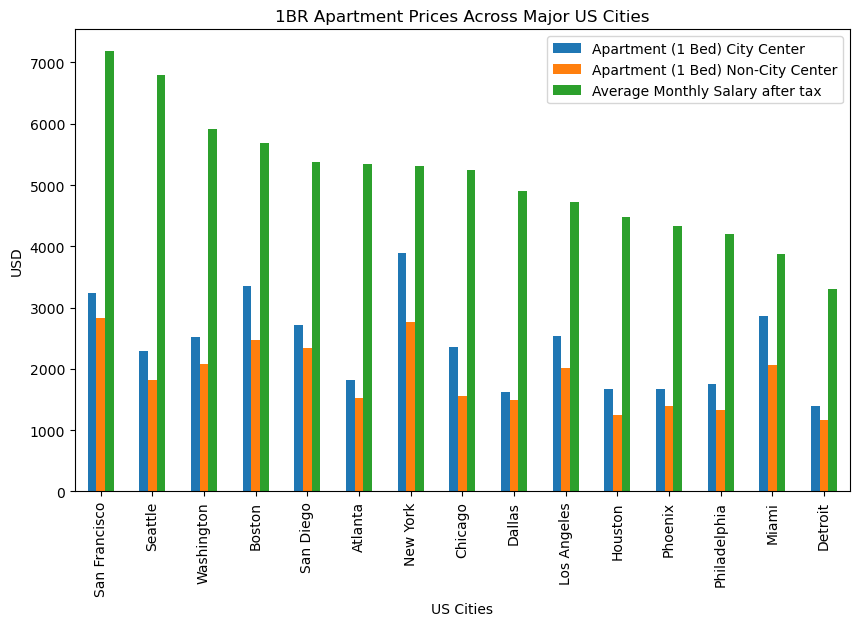

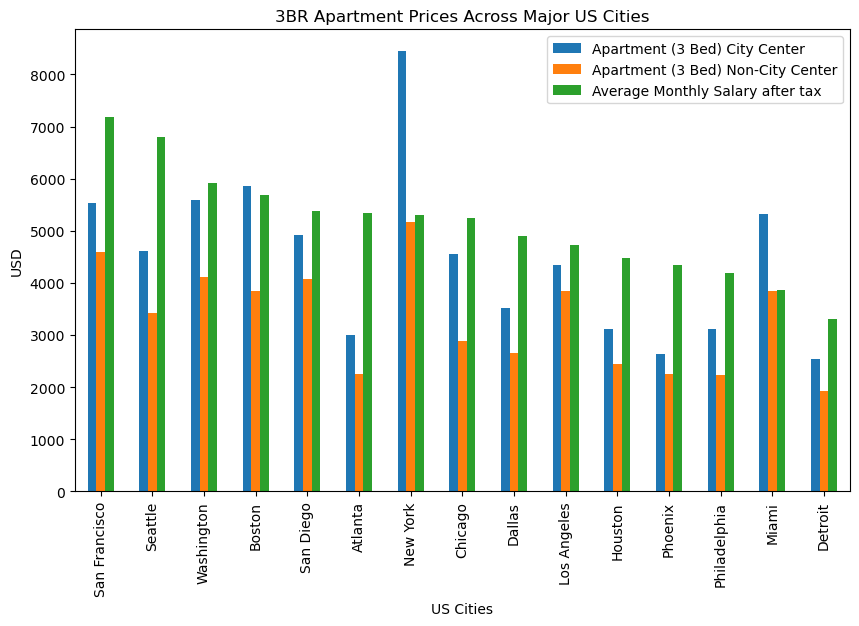

In [ ]:
import ast
import matplotlib.pyplot as plt # for additional customization

#Build a table of the 10 most populated cities and rank the cost of a 1 Bedroom apartment in the city center
cities = city_population_df[0:15]
cities_cost = dict()

for index,row in cities.iterrows():
    try:
        city = row.values[1].strip()
        city_costs= cost_living_df.loc[cost_living_df['City'] == city]
        avg_1BR_citycenter = str_to_tuple(city_costs['Apartment (1 bedroom) in City Centre'].values[0])[0]
        avg_3BR_citycenter = str_to_tuple(city_costs['Apartment (3 bedrooms) in City Centre'].values[0])[0]
        avg_1BR_non_citycenter = str_to_tuple(city_costs['Apartment (1 bedroom) Outside of Centre'].values[0])[0]
        avg_3BR_non_citycenter = str_to_tuple(city_costs['Apartment (3 bedrooms) Outside of Centre'].values[0])[0]

        #avg_meal = str_to_tuple(city_costs["Meal, Inexpensive Restaurant"].values[0])[0]
        avg_salary = str_to_tuple(city_costs['Average Monthly Net Salary (After Tax)'].values[0])[0]
        cities_cost[city] = [avg_1BR_citycenter, avg_1BR_non_citycenter, avg_3BR_non_citycenter, avg_3BR_citycenter, avg_salary]
    except:
        pass

df = pd.DataFrame(cities_cost)
df.index = ['Apartment (1 Bed) City Center','Apartment (1 Bed) Non-City Center','Apartment (3 Bed) Non-City Center','Apartment (3 Bed) City Center','Average Monthly Salary after tax']
df = df.T
df = df.map(lambda x: float(str(x).replace(',', '')))
df1 = df.sort_values(by = 'Average Monthly Salary after tax',ascending=False)

#1 Bedroom Costs 
city_1BR_costs = df1[['Apartment (1 Bed) City Center','Apartment (1 Bed) Non-City Center','Average Monthly Salary after tax']]
# Plotting a bar graph for the 'Values' column
city_1BR_costs.plot(kind='bar',figsize=(10,6))
plt.title('1BR Apartment Prices Across Major US Cities')
plt.ylabel('USD')
plt.xlabel('US Cities')

#2 Bedroom costs
city_3BR_costs = df1[['Apartment (3 Bed) City Center','Apartment (3 Bed) Non-City Center','Average Monthly Salary after tax']]
# Plotting a bar graph for the 'Values' column
city_3BR_costs.plot(kind='bar',figsize=(10,6))
plt.title('3BR Apartment Prices Across Major US Cities')
plt.ylabel('USD')
plt.xlabel('US Cities')



In [320]:
#Summary Stats for US City Apartment Prices
df1.describe()

,Apartment (1 Bed) City Center,Apartment (1 Bed) Non-City Center,Apartment (3 Bed) Non-City Center,Apartment (3 Bed) City Center,Average Monthly Salary after tax
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,2378.944000,1871.336667,3304.003333,4474.726667,5109.686000
std,738.839548,545.413409,995.068384,1578.404569,1039.372301
min,1399.890000,1163.380000,1933.170000,2541.670000,3298.450000
25%,1709.990000,1442.035000,2350.135000,3119.210000,4404.285000
50%,2360.910000,1825.000000,3430.240000,4554.550000,5251.120000
75%,2782.780000,2213.505000,3965.460000,5435.475000,5529.770000
max,3897.070000,2821.740000,5177.600000,8443.100000,7181.950000


Determine if there is an obvious trend between Quality of Life VS Population of a city or Traffic/Commute vs Population

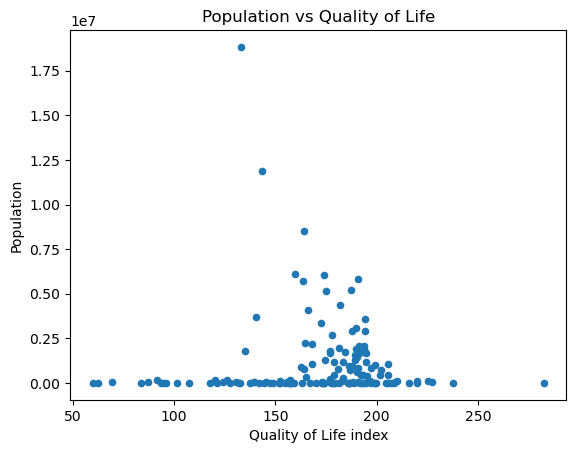

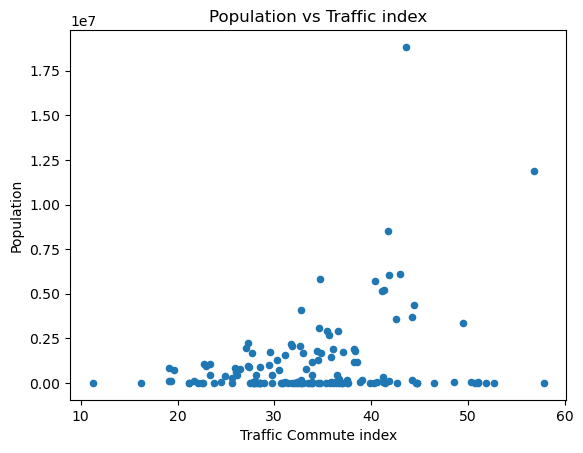

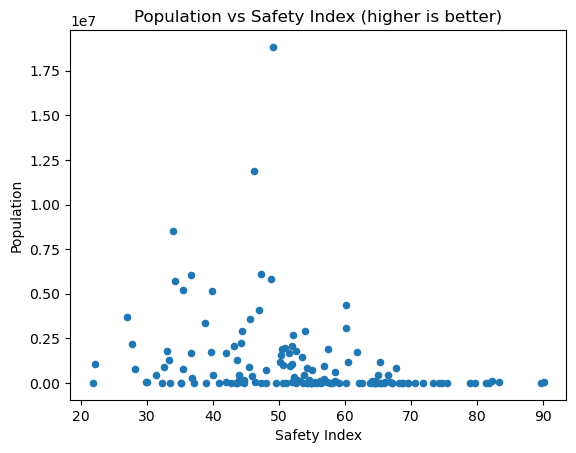

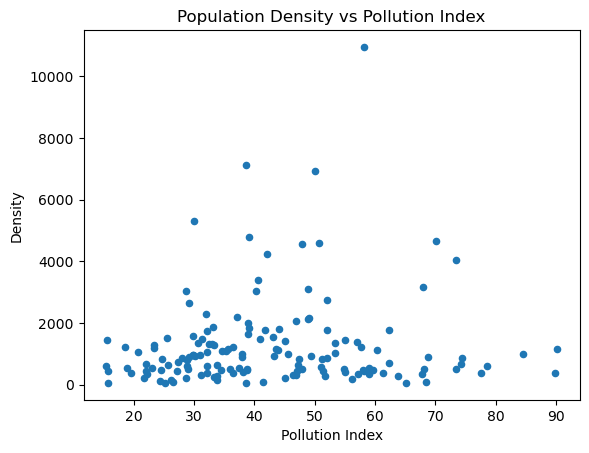

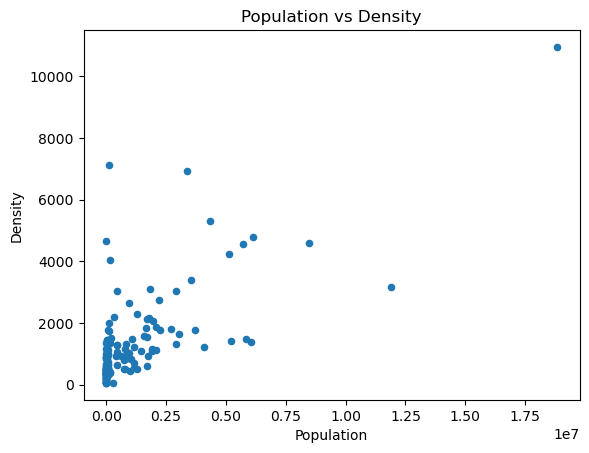

In [377]:
import pandas as pd
import matplotlib.pyplot as plt

#Build a table of the 100 most populated cities
cities = city_population_df
city_quality = []
cities_used = []

for index,row in cities.iterrows():
    city = row['city']
    population = row['population']
    density = row['density']

    if city in cities_used:
        continue
    try:
        quality_life_data = quality_life_df[quality_life_df['City'] == city]
        quality_rating = float(str_to_tuple(quality_life_data['ƒQuality of Life Index:'].values[0])[0])
        traffic = float(str_to_tuple(quality_life_data['Traffic Commute Time Index'].values[0])[0])
        pollution = float(str_to_tuple(quality_life_data['Pollution Index'].values[0])[0])
        safety = float(str_to_tuple(quality_life_data['Safety Index'].values[0])[0])
        if quality_rating:
            city_quality.append((city, quality_rating, safety, traffic, pollution, population, density))
            cities_used.append(city)
    except:
        pass

df2= pd.DataFrame(city_quality,columns=['City','Quality of Life index', 'Safety Index','Traffic Commute index','Pollution Index','Population','Density'])

#Population vs Quality of Life index
df2.plot.scatter(x='Quality of Life index',y='Population')
plt.title('Population vs Quality of Life')
plt.show()

#Population vs Traffic/Commute index
df2.plot.scatter(x = 'Traffic Commute index', y = 'Population')
plt.title('Population vs Traffic index')
plt.show()

#Population vs Safety Index
df2.plot.scatter(x = 'Safety Index', y = 'Population')
plt.title('Population vs Safety Index (higher is better)')
plt.show()

#Density vs Pollution
df2.plot.scatter(x = 'Pollution Index', y = 'Density')
plt.title('Population Density vs Pollution Index')
plt.show()

#Density vs Population
df2.plot.scatter(x= 'Population', y='Density')
plt.title('Population vs Density')
plt.show()


In [ ]:
#Correlation
correlation = df2[['Quality of Life index','Traffic Commute index','Pollution Index','Population','Density','Safety Index']].corr()
print(correlation)

def extract_value(val):
    t = str_to_tuple(val)
    if t and t[0] != '?':
        try:
            index_value = float(t[0])
            return index_value
        except:
            return None
    else:
        return None

df_purchase_power = quality_life_df.sort_values(
    by= 'Purchase Power Index',
    key= lambda col: col.map(extract_value),
    ascending= False,
    na_position='last'
)

                       Quality of Life index  Traffic Commute index  \
Quality of Life index               1.000000              -0.572522   
Traffic Commute index              -0.572522               1.000000   
Pollution Index                    -0.791795               0.497696   
Population                         -0.009742               0.283057   
Density                            -0.054006               0.311440   
Safety Index                        0.393926              -0.292510   

                       Pollution Index  Population   Density  Safety Index  
Quality of Life index        -0.791795   -0.009742 -0.054006      0.393926  
Traffic Commute index         0.497696    0.283057  0.311440     -0.292510  
Pollution Index               1.000000    0.123151  0.096097     -0.365046  
Population                    0.123151    1.000000  0.706051     -0.263475  
Density                       0.096097    0.706051  1.000000     -0.201844  
Safety Index                 -0.365046  

KeyError: 'Purchase Power Index'

In [ ]:
import re

#Labor and Labor Population Data
unemployment = []
unemployment_quality = []
cities_found = []

for index,row in labor_df.iterrows():
    population = row['Labor Force Population']
    city = row['City']
    state = row['State Abbreviation']
    try:
        data = unemployment_df[unemployment_df['City'] == city]
        unemployment_rate = data['Unemployment Rate'].values[0]
        unemployment.append((city,state,population,unemployment_rate))
    except:    
        pass

for city,state,population,unemployment_rate in unemployment:
    cities = city.split('-')
    pattern = r'\b(county|city|town|township|plantation|unorganized)\b'
    for city in cities:
        city = re.sub(pattern,'',city,flags=re.IGNORECASE)
        print(city)
        if city in cities_found:
            continue
        try:
            quality_life_data = quality_life_df[quality_life_df['City'] == city]
            quality_rating = float(str_to_tuple(quality_life_data['ƒQuality of Life Index:'].values[0])[0])
            unemployment_quality.append((city,state,population,unemployment_rate,quality_rating))

            cities_found.append(city)
        except:
            pass

df4 = pd.DataFrame(unemployment_quality, columns = ['City','State','Population','Unemployment Rate','Quality of Life Rating'])

#Population vs Quality of Life index
df4.plot.scatter(x='Unemployment Rate',y='Quality of Life Rating')
plt.title('Unemployment vs Quality of Life')
plt.show()

In [ ]:

df3 = pd.DataFrame(unemployment,columns = ['City','Population','Unemployment Rate'])
df3[['Population','Unemployment Rate']].corr()
df3.describe()
